# Analysis of human and model behavior across physical domains

**The purpose of this notebook is to:** 
* Apply preprocessing to human behavioral data
* Visualize distribution and compute summary statistics over **human** physical judgments
* Visualize distribution and compute summary statistics over **model** physical judgments
* Conduct human-model comparisons
* Output CSV that can be re-loaded into R notebook for statistical modeling & fancy visualizations

**This notebook depends on:**
* Running `./generate_dataframes.py` (INTERNAL USE ONLY)
* Running `./upload_results.py` (INTERNAL USE ONLY)
* Running `./download_results.py` (PUBLIC USE)

## setup

#### Load packages

In [1]:
import os
import sys
import urllib, io

sys.path.append('./analysis_helpers')
from importlib import reload

import numpy as np
import scipy.stats as stats
import pandas as pd

import analysis_helpers as h

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

from tqdm.notebook import tqdm

import  matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.style.use('seaborn-white')

import seaborn as sns

%matplotlib inline
import scipy.stats
import sklearn.metrics
import random

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

#### options

In [2]:
# display all columns
pd.set_option('display.max_columns', None)

# seaborn plotting themes
sns.set_context('talk')
sns.set_style("whitegrid")

#### set up paths and directories

In [3]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
## add helpers to python path
if os.path.join(analysis_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(analysis_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir]]

### load human data

In [4]:
from experiment_meta import *
HEM = pd.DataFrame(NEURIPS2021_EXPS) # HEM = "human experiment metadata"
HEM

,study,bucket_name,stim_version,iterationName
0,dominoes_pilot,human-physics-benchmarking-dominoes-pilot,production_1,production_1_testing
1,collision_pilot,human-physics-benchmarking-collision-pilot,production_2,production_2_testing
2,towers_pilot,human-physics-benchmarking-towers-pilot,production_2,production_2_testing
3,linking_pilot,human-physics-benchmarking-linking-pilot,production_2,production_2_testing
4,containment_pilot,human-physics-benchmarking-containment-pilot,production_2,production_2_testing
5,rollingsliding_pilot,human-physics-benchmarking-rollingsliding-pilot,production_2,production_2_testing
6,drop_pilot,human-physics-benchmarking-drop-pilot,production_2,production_2_testing
7,clothiness_pilot,human-physics-benchmarking-clothiness-pilot,production_2,production_2_testing


In [5]:
SCENARIOS = sorted([n.split("_")[0] for n in HEM['study'].unique()])

In [6]:
## get paths to all human response data
data_paths = [os.path.join(csv_dir,'humans',i) for i in os.listdir(os.path.join(csv_dir,'humans'))]
resp_paths = [i for i in data_paths if i.split('/')[-1].split('-')[0]=='human_responses']
assert len(resp_paths)==8

In [7]:
## also load all human data into a big dataframe
HD = pd.concat([h.apply_exclusion_criteria(h.load_and_preprocess_data(p)) for p in resp_paths])
print("Loaded {} lines".format(len(HD)))

Loaded 105000 lines


### load model data

In [8]:
## get paths to all model data
model_data_paths = [os.path.join(csv_dir,'models',i) for i in os.listdir(os.path.join(csv_dir,'models'))]
model_res_paths = [i for i in model_data_paths if i.split('.')[-1] == "csv"]

In [9]:
## load all model results into a single dataframe
MD = pd.concat([pd.read_csv(p).assign(filename=p.split('/')[-1]) for p in model_res_paths])
print("Loaded {} rows".format(len(MD)))

Loaded 157062 rows


In [10]:
# a couple of import steps (restore original scenario names, add single prediction value, add correctness column)
MD = h.process_model_dataframe(MD)

In [11]:
#check for duplicated rows
if len(MD.duplicated()) > 0:
    print("⚠️There are {} duplicated rows!".format(np.sum(MD.duplicated())))
    MD = MD[~MD.duplicated(h.MODEL_COLS+["Stimulus Name"],keep="first")]
    print("Removed duplicates, {} rows left".format(len(MD)))

⚠️There are 0 duplicated rows!
Removed duplicates, 157062 rows left


In [12]:
# save model kinds to variable
MODELS = list(MD["Model Kind"].unique())

In [13]:
print("We get the following kinds of models:")
display(MODELS)

We get the following kinds of models:


['VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_same',
 'RPIN_R-CNN_1.0_L2 on 2D position_all_but_this_L2 on 2D position_1_same',
 'RPIN_R-CNN_2.0_L2 on 2D position_all_but_this_L2 on 2D position_2_same',
 'RPIN_R-CNN_1.0_L2 on 2D position_all_L2 on 2D position_1_same',
 'RPIN_R-CNN_2.0_L2 on 2D position_all_L2 on 2D position_2_same',
 'RPIN_R-CNN_1.0_L2 on 2D position_same_L2 on 2D position_1_same',
 'RPIN_R-CNN_2.0_L2 on 2D position_same_L2 on 2D position_2_same',
 'SVG_VGG_1.0_VAE_all_but_this_VAE_1_same',
 'SVG_VGG_1.0_VAE_all_VAE_1_same',
 'SVG_VGG_1.0_VAE_same_VAE_1_same',
 'VGGFrozenLSTM_VGG_nan_nan_nan_L2 on latent_0_same',
 'CSWM_CSWM encoder_0.0_Contrastive_all_but_this_Contrastive_0_same',
 'CSWM_CSWM encoder_0.0_Contrastive_all_Contrastive_0_same',
 'CSWM_CSWM encoder_0.0_Contrastive_same_Contrastive_0_same',
 'DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_same',
 'DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_same',
 'OP3_OP3 encoder_0.0_Image Reconstruction_all_but_this_Im

### exclude bad stims

In [14]:
stim_comparision = pd.merge(pd.DataFrame(MD.groupby('Canon Stimulus Name')['Actual Outcome'].first()).reset_index(),pd.DataFrame(HD.groupby('stim_ID')['target_hit_zone_label'].first()).reset_index(),left_on='Canon Stimulus Name',right_on='stim_ID')

bad_stims = stim_comparision[stim_comparision['Actual Outcome'] != stim_comparision['target_hit_zone_label']]['Canon Stimulus Name']
print("There are {} bad stims".format(len(bad_stims)))

There are 37 bad stims


In [15]:
#Exclude bad stims
HD = HD[~HD['stim_ID'].isin(bad_stims)]
MD = MD[~MD['Canon Stimulus Name'].isin(bad_stims)]

In [16]:
#Also exclude stims from the rollingsliding ledge subset
HD = HD[~HD['stim_ID'].str.contains("rollingSliding_simple_ledge")]
MD = MD[~MD['Canon Stimulus Name'].str.contains("rollingSliding_simple_ledge")]

In [17]:
MD

,Model,Readout Train Data,Readout Test Data,Train Accuracy,Test Accuracy,Readout Type,Predicted Prob_false,Predicted Prob_true,Predicted Outcome,Actual Outcome,Stimulus Name,Encoder Type,Dynamics Type,Encoder Pre-training Task,Encoder Pre-training Dataset,Encoder Pre-training Seed,Encoder Training Task,Encoder Training Dataset,Encoder Training Seed,Dynamics Training Task,Dynamics Training Dataset,Dynamics Training Seed,filename,correct,Canon Stimulus Name,Encoder Training Dataset Type,Dynamics Training Dataset Type,Readout Train Data Type,ModelID,Model Kind
0,VGGFrozenMLP,linking,linking,1.0,0.611650,A,0.000000e+00,1.000000e+00,1,0,pilot_linking_nl1-5_aNone_bCube_occ0_dis0_boxr...,VGG,MLP,ImageNet classification,ImageNet,NaN,NaN,NaN,NaN,L2 on latent,no_linking,0,VGGFrozenMLP_results.csv,False,pilot_linking_nl1-5_aNone_bCube_occ0_dis0_boxr...,NaN,all_but_this,same,VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no...,VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_same
1,VGGFrozenMLP,linking,linking,1.0,0.611650,A,1.614928e-08,1.000000e+00,1,0,pilot_linking_nl1-5_aNone_bCube_occ0_dis0_boxr...,VGG,MLP,ImageNet classification,ImageNet,NaN,NaN,NaN,NaN,L2 on latent,no_linking,0,VGGFrozenMLP_results.csv,False,pilot_linking_nl1-5_aNone_bCube_occ0_dis0_boxr...,NaN,all_but_this,same,VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no...,VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_same
2,VGGFrozenMLP,linking,linking,1.0,0.611650,A,0.000000e+00,1.000000e+00,1,1,pilot_linking_nl1-5_aNone_bCube_occ0_dis0_boxr...,VGG,MLP,ImageNet classification,ImageNet,NaN,NaN,NaN,NaN,L2 on latent,no_linking,0,VGGFrozenMLP_results.csv,True,pilot_linking_nl1-5_aNone_bCube_occ0_dis0_boxr...,NaN,all_but_this,same,VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no...,VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_same
3,VGGFrozenMLP,linking,linking,1.0,0.611650,A,9.019755e-08,9.999999e-01,1,0,pilot_linking_nl1-5_aNone_bCube_occ0_dis0_boxr...,VGG,MLP,ImageNet classification,ImageNet,NaN,NaN,NaN,NaN,L2 on latent,no_linking,0,VGGFrozenMLP_results.csv,False,pilot_linking_nl1-5_aNone_bCube_occ0_dis0_boxr...,NaN,all_but_this,same,VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no...,VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_same
4,VGGFrozenMLP,linking,linking,1.0,0.611650,A,0.000000e+00,1.000000e+00,1,1,pilot_linking_nl1-5_aNone_bCube_occ0_dis0_boxr...,VGG,MLP,ImageNet classification,ImageNet,NaN,NaN,NaN,NaN,L2 on latent,no_linking,0,VGGFrozenMLP_results.csv,True,pilot_linking_nl1-5_aNone_bCube_occ0_dis0_boxr...,NaN,all_but_this,same,VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no...,VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_same
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15736,OP3,towers,towers,1.0,0.479339,C,1.000000e+00,6.464184e-11,0,1,pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_b...,OP3 encoder,OP3 dynamics,NaN,NaN,NaN,Image Reconstruction,no_towers,0.0,Image Reconstruction,no_towers,0,OP3_results.csv,False,pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_b...,all_but_this,all_but_this,same,OP3_OP3 encoder_0.0_Image Reconstruction_no_to...,OP3_OP3 encoder_0.0_Image Reconstruction_all_b...
15737,OP3,towers,towers,1.0,0.479339,C,3.463896e-14,1.000000e+00,1,1,pilot_towers_nb4_SJ025_mono1_dis1_occ1_boxroom...,OP3 encoder,OP3 dynamics,NaN,NaN,NaN,Image Reconstruction,no_towers,0.0,Image Reconstruction,no_towers,0,OP3_results.csv,True,pilot_towers_nb4_SJ025_mono1_dis1_occ1_boxroom...,all_but_this,all_but_this,same,OP3_OP3 encoder_0.0_Image Reconstruction_no_to...,OP3_OP3 encoder_0.0_Image Reconstruction_all_b...
15738,OP3,towers,towers,1.0,0.479339,C,9.975404e-01,2.459590e-03,0,1,pilot_towers_nb3_fr015_SJ025_mono1_dis0_occ0_t...,OP3 encoder,OP3 dynamics,NaN,NaN,NaN,Image Reconstruction,no_towers,0.0,Image Reconstruction,no_towers,0,OP3_results.csv,False,pilot_towers_nb3_fr015_SJ025_mono1_dis0_occ0_t...,all_but_this,all_but_this,same,OP3_OP3 encoder_0.0_Image Reconstruction_no_to...,OP3_OP3 encoder_0.0_Image Rec

### generate labels for regression analysis
* Comparison 1: Visual encoder architecture (ConvNet [SVG/VGGFrozenLSTM] vs. transformer [DEITFrozenLSTM] … DEITFrozenMLP vs. SVG/VGGFrozenMLP)
* Comparison 2: Dynamics model RNN vs. MLP (LSTM vs. MLP for above)
* Comparison 3: Among unsupervised models, object-centric vs. non-object-centric
        * {CSWM, OP3} vs. {SVG}
* Comparison 4: Latent vs. pixel reconstruction loss
        * CSWM vs. OP3
* Comparison 5: RPIN vs. CSWM/OP3 (“supervised explicit object-centric” vs. “unsupervised implicit object-centric”)

Dimensions: 
* “Visual encoder architecture” : [“ConvNet” “Transformer” “Neither”]
* “Dynamics model architecture” : [“LSTM”, “MLP”, “Neither”]
* “ObjectCentric”: [TRUE, FALSE, NA]
* “Supervised”: [TRUE, FALSE]
* “SelfSupervisedLoss”: [“latent”, “pixel”, “NA”]


In [18]:
#“Visual encoder architecture” : [“ConvNet” “Transformer” “Neither”]
MD['Visual encoder architecture'] = "Neither"
MD.loc[(MD['Model'].str.contains("SVG")) | (MD['Model'].str.contains("VGG")),'Visual encoder architecture'] = "ConvNet"
MD.loc[(MD['Model'].str.contains("DEIT")) | (MD['Model'].str.contains("VGG")),'Visual encoder architecture'] = "Transformer"

In [19]:
# “Dynamics model architecture” : [“LSTM”, “MLP”, “Neither”]
MD['Dynamics model architecture'] = "Neither"
MD.loc[(MD['Model'].str.contains("LSTM")),'Dynamics model architecture'] = "LSTM"
MD.loc[(MD['Model'].str.contains("MLP")),'Dynamics model architecture'] = "MLP"

In [20]:
# ObjectCentric”: [TRUE, FALSE, NA]
MD['ObjectCentric'] = np.nan
MD.loc[(MD['Model'].str.contains("CSWM")) | (MD['Model'].str.contains("OP3")),'ObjectCentric'] = True
MD.loc[(MD['Model'].str.contains("SVG")),'ObjectCentric'] = False
# MD['ObjectCentric'] = MD['ObjectCentric'].astype(bool)

In [21]:
# Supervised”: [TRUE, FALSE]
MD['Supervised'] = np.nan
MD.loc[(MD['Model'].str.contains("RPIN")) | (MD['Model'].str.contains("DPI")),'Supervised'] = True
MD.loc[(MD['Model'].str.contains("CSWM")) | (MD['Model'].str.contains("OP3")) | (MD['Model'].str.contains("SVG") | (MD['Model'].str.contains("VGG"))),'Supervised'] = False
# MD['Supervised'] = MD['Supervised'].astype(bool)

In [22]:
# SelfSupervisedLoss”: [“latent”, “pixel”, “NA”]
MD['SelfSupervisedLossSelfSupervisedLoss'] = "NA"
MD.loc[(MD['Model'].str.contains("CSWM")),'SelfSupervisedLoss'] = "latent"
MD.loc[(MD['Model'].str.contains("OP3")) | (MD['Model'].str.contains("VGG")) | (MD['Model'].str.contains("SVG") | (MD['Model'].str.contains("VGG"))),'SelfSupervisedLoss'] = "pixel"

In [23]:
#save as model identifying column
MODEL_COLS = h.MODEL_COLS + ['Visual encoder architecture','Dynamics model architecture','ObjectCentric','Supervised','SelfSupervisedLossSelfSupervisedLoss']

### generate summary table of human 95% CIs for accuracy across all scenarios

In [24]:
## init human_bootstrapped_accuracy for plotting
human_bootstrapped_accuracy = pd.DataFrame()

for exp_ind, exp_name in enumerate(resp_paths):
    
    ## get path to response data
    path_to_data = resp_paths[exp_ind]

    ## load data and apply preprocessing
    _D = h.load_and_preprocess_data(path_to_data)
    scenarioName = _D.scenarioName.values[0]
    print('Currently analyzing the {} experiment.'.format(_D.scenarioName.values[0]))
    clear_output(wait=True)
    
    ## apply exclusion criteria
    D = h.apply_exclusion_criteria(_D)

    ## compute bootstrapped sampling distributions of accuracy
    Dacc = D.groupby('prolificIDAnon').agg({'correct':np.mean})
    bootmeans = h.bootstrap_mean(Dacc, col='correct', nIter=1000)

    obsmean = np.mean(Dacc.correct.values)
    bootmean = np.mean(bootmeans)
    lb = np.percentile(bootmeans,2.5)
    ub = np.percentile(bootmeans,97.5)
    pct25 = np.percentile(Dacc,2.5)
    pct975 = np.percentile(Dacc,97.5)
    ## merge bootstrapped accuracy estimates
    if len(human_bootstrapped_accuracy)==0:
        human_bootstrapped_accuracy = pd.DataFrame(['human', scenarioName, obsmean,bootmean,lb,ub, pct25, pct975]).transpose()
    else:
        human_bootstrapped_accuracy = pd.concat([human_bootstrapped_accuracy, pd.DataFrame(['human', scenarioName, obsmean,bootmean,lb,ub, pct25, pct975]).transpose()],axis=0)
        
## add column names        
human_bootstrapped_accuracy.columns=['agent','scenario','obs_mean', 'boot_mean', 'ci_lb', 'ci_ub', 'pct_2.5', 'pct_97.5']

## save out human_bootstrapped_accuracy to re-plot in R
if not os.path.exists(os.path.join(csv_dir, 'summary')):
    os.makedirs(os.path.join(csv_dir, 'summary'))    
human_bootstrapped_accuracy.to_csv(os.path.join(csv_dir, 'summary','human_accuracy_by_scenario.csv'), index=False)
print('Saved to file! Done.')

Saved to file! Done.


In [25]:
human_bootstrapped_accuracy

,agent,scenario,obs_mean,boot_mean,ci_lb,ci_ub,pct_2.5,pct_97.5
0,human,collision,0.808511,0.808485,0.798793,0.81766,0.704333,0.88
0,human,rollingsliding,0.882986,0.882948,0.875411,0.890696,0.789167,0.94
0,human,dominoes,0.692791,0.6927,0.684341,0.701163,0.614167,0.76
0,human,drop,0.743656,0.743722,0.73541,0.751326,0.666667,0.804667
0,human,clothiness,0.679394,0.679202,0.663331,0.693639,0.543333,0.766667
0,human,linking,0.643182,0.643234,0.631968,0.654545,0.536833,0.744333
0,human,containment,0.766988,0.766892,0.758072,0.775026,0.686667,0.839667
0,human,towers,0.763137,0.763012,0.754975,0.770982,0.669333,0.826


### Human-human consistency across stimuli (within scenario)
We will analyze human-human consistency by computing the mean correlation between (binary) response vectors produced by each human participant across all stimuli within each scenario. 



#### Correlation

In [26]:
## init human_boot_corr for plotting
human_boot_corr = pd.DataFrame()

for exp_ind, exp_name in enumerate(resp_paths):
    
    ## get path to response data
    path_to_data = resp_paths[exp_ind]

    ## load data and apply preprocessing
    _D = h.load_and_preprocess_data(path_to_data)
    scenarioName = _D.scenarioName.values[0]
    print('Currently analyzing the {} experiment.'.format(_D.scenarioName.values[0]))
    clear_output(wait=True)

    ## apply exclusion criteria
    D = h.apply_exclusion_criteria(_D)
    
    ## create response feature matrix (numSubs x numTrialsPerSub)
    D2 = D.sort_values(by=['prolificIDAnon','stim_ID']).reset_index(drop=True)
    numSubs = len(np.unique(D['prolificIDAnon'].values))
    numTrialsPerSub = int(len(D)/numSubs)
    respMat = np.reshape(D2['responseBool'].values, (numSubs,numTrialsPerSub)) 

    ## sanity check that the reshape operation happened correctly
    assert len([i for (i,j) in list(zip(respMat[0],D2[:150]['responseBool'].values)) if i!=j])==0    
    
    ## get pairwise correlations
    dists = 1-scipy.spatial.distance.pdist(respMat, metric='correlation')
    corrMat = scipy.spatial.distance.squareform(dists)
    
    ## get percentiles over pairwise corrs
    pairwiseCorrs = corrMat[np.triu_indices(n=len(corrMat), k=1)]
    lb = np.percentile(pairwiseCorrs, 2.5)
    med = np.percentile(pairwiseCorrs, 50)
    ub = np.percentile(pairwiseCorrs, 97.5)  
        
    if len(human_boot_corr)==0:
        human_boot_corr = pd.DataFrame(['human', scenarioName, lb, med, ub]).transpose()
    else:
        human_boot_corr = pd.concat([human_boot_corr, pd.DataFrame(['human', scenarioName, lb, med, ub]).transpose()],axis=0)
        
## add column names        
human_boot_corr.columns=['agent','scenario','corr_lb', 'corr_med', 'corr_ub']

## save out human_boot_corr to re-plot in R
if not os.path.exists(os.path.join(csv_dir, 'summary')):
    os.makedirs(os.path.join(csv_dir, 'summary'))    
human_boot_corr.to_csv(os.path.join(csv_dir, 'summary','human_pairwiseCorrs_by_scenario.csv'), index=False)
print('Saved to file! Done.')

Saved to file! Done.


In [27]:
human_boot_corr

,agent,scenario,corr_lb,corr_med,corr_ub
0,human,collision,0.388046,0.62822,0.776057
0,human,rollingsliding,0.506253,0.713836,0.851243
0,human,dominoes,0.231102,0.425943,0.591814
0,human,drop,0.266334,0.501544,0.681139
0,human,clothiness,0.065426,0.349287,0.549326
0,human,linking,0.114636,0.386807,0.569892
0,human,containment,0.306122,0.559038,0.725013
0,human,towers,0.299731,0.565581,0.725722


#### Cohen's $\kappa$

In [28]:
## init human_boot_cohenk for plotting
human_boot_cohenk = pd.DataFrame()

for exp_ind, exp_name in enumerate(resp_paths):
    
    ## get path to response data
    path_to_data = resp_paths[exp_ind]

    ## load data and apply preprocessing
    _D = h.load_and_preprocess_data(path_to_data)
    scenarioName = _D.scenarioName.values[0]
    print('Currently analyzing the {} experiment.'.format(_D.scenarioName.values[0]))
    clear_output(wait=True)

    ## apply exclusion criteria
    D = h.apply_exclusion_criteria(_D)
    
    ## create response feature matrix (numSubs x numTrialsPerSub)
    D2 = D.sort_values(by=['prolificIDAnon','stim_ID']).reset_index(drop=True)
    numSubs = len(np.unique(D['prolificIDAnon'].values))
    numTrialsPerSub = int(len(D)/numSubs)
    respMat = np.reshape(D2['responseBool'].values, (numSubs,numTrialsPerSub)) 

    ## sanity check that the reshape operation happened correctly
    assert len([i for (i,j) in list(zip(respMat[0],D2[:150]['responseBool'].values)) if i!=j])==0    
      
    ## compute Cohen's kappa
    ## with a horrific double loop
    kappas = []
    for i in range(respMat.shape[0]): # for each participant
        for j in range(i+1,respMat.shape[0]): # compare to every participant after them
            assert i != j
            kappa = sklearn.metrics.cohen_kappa_score(respMat[i],respMat[j])
            kappas.append(kappa)
    
    ## get percentiles over pairwise corrs
    lb = np.percentile(kappas, 2.5)
    med = np.percentile(kappas, 50)
    ub = np.percentile(kappas, 97.5)  
        
    if len(human_boot_cohenk)==0:
        human_boot_cohenk = pd.DataFrame(['human', scenarioName, lb, med, ub]).transpose()
    else:
        human_boot_cohenk = pd.concat([human_boot_cohenk, pd.DataFrame(['human', scenarioName, lb, med, ub]).transpose()],axis=0)
        
## add column names        
human_boot_cohenk.columns=['agent','scenario','corr_lb', 'corr_med', 'corr_ub']

## save out human_boot_cohenk to re-plot in R
if not os.path.exists(os.path.join(csv_dir, 'summary')):
    os.makedirs(os.path.join(csv_dir, 'summary'))    
human_boot_cohenk.to_csv(os.path.join(csv_dir, 'summary','human_pairwiseCohensKs_by_scenario.csv'), index=False)
print('Saved to file! Done.')

Saved to file! Done.


In [29]:
human_boot_cohenk

,agent,scenario,corr_lb,corr_med,corr_ub
0,human,collision,0.381969,0.621826,0.773353
0,human,rollingsliding,0.490152,0.707031,0.85095
0,human,dominoes,0.210147,0.410819,0.585372
0,human,drop,0.260437,0.494367,0.678875
0,human,clothiness,0.05451,0.34266,0.546924
0,human,linking,0.109512,0.369462,0.560538
0,human,containment,0.284806,0.546667,0.719987
0,human,towers,0.285117,0.549918,0.720673


## Visualize distribution of model physical judgments, by domain

## Compute summary statistics over model physical judgments, by domain

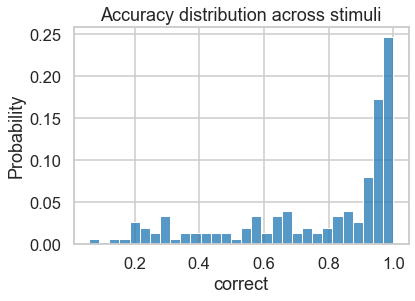

In [30]:
Dacc = D.groupby('stim_ID').agg({'correct':np.mean})
p = sns.histplot(data=Dacc, x='correct', bins=30, stat='probability')
t = plt.title('Accuracy distribution across stimuli')

## Conduct human-model comparisons
We will compare human and model behavior in two ways: **absolute performance** and **response pattern.**

#### **Absolute Performance** 
We will compare the accuracy of each model to the mean accuracy of humans, for each scenario. 
To do this, we will first compute estimates of mean human accuracy for each scenario and construct 95% confidence intervals for each of these estimates. 
These confidence intervals will be constructed by bootstrapping: specifically, for an experiment with N participants, we will resample N participants with replacement and compute the proportion correct for that bootstrapped sample. We will take repeat this resampling procedure 1000 times to generate a sampling distribution for the mean proportion correct. The 2.5th and 97.5th percentile will be extracted from this sampling distribution to provide the lower and upper bounds of the 95% confidence interval.

For each model, we will then compare their proportion correct (a point estimate) to the human confidence interval. 

In [31]:
# group model data by scenario
MD_by_scenario = MD.groupby(['Readout Test Data','ModelID']).agg(
        {**{ 'correct':'mean' },
         **{ col:'first' for col in MODEL_COLS+h.DATASET_ABSTRACTED_COLS} #save model identifying data as well
        })

In [32]:
accuracies = {}

for scenario in sorted(MD['Readout Test Data'].unique()):
    print("Now running scenario",scenario)
    _MD_by_scenario = MD_by_scenario.loc[[scenario]]
    for _,model_row in list(_MD_by_scenario.iterrows()):
        #each model is one row of MD
        human_row = human_bootstrapped_accuracy.query("scenario == @scenario")
#         assert len(model_row) == len(human_row) == 1
        correct_ratio = model_row['correct']/human_row['obs_mean']
        correct_diff = model_row['correct'] - human_row['obs_mean']
        accuracies[(scenario,model_row.name[1])] = {**{
                                                    'scenario': scenario,
                                                    'ratio': float(correct_ratio), 
                                                    'diff': float(correct_diff),
                                                    'human_correct': float(human_row['obs_mean']),
                                                    'model_correct': float(model_row['correct']),
                                                    },**{col: model_row[col] for col in MODEL_COLS+h.DATASET_ABSTRACTED_COLS}} # save information for model identification
    clear_output(wait=True)

model_human_accuracies = pd.DataFrame(accuracies).transpose()  
model_human_accuracies.to_csv(os.path.join(csv_dir, 'summary','model_human_accuracies.csv'), index=False)
print('Saved to file. Done!')

Saved to file. Done!


In [33]:
model_human_accuracies

scenario  \
clothiness CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...  clothiness   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...  clothiness   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...  clothiness   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...  clothiness   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...  clothiness   
...                                                                   ...   
towers     VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...      towers   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...      towers   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow...      towers   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow...      towers   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow...      towers   

                                                                  ratio  \
clothiness CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...  1.013318   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...  0.791424   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...  0.747045   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...  0.872785   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...  0.784027   
...                                                                 ...   
towers     VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...  0.838863   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...  0.866276   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow...  0.970449   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow...  0.816932   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow...  0.822414   

                                                                   diff  \
clothiness CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...  0.009048   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti... -0.141705   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti... -0.171856   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co... -0.086429   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co... -0.146731   
...                                                                 ...   
towers     VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...  -0.12297   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_... -0.102049   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow... -0.022551   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow... -0.139706   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow... -0.135522   

                                                              human_correct  \
clothiness CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...      0.679394   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...      0.679394   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...      0.679394   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...      0.679394   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...      0.679394   
...                                                                     ...   
towers     VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...      0.763137   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...      0.763137   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow...      0.763137   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow...      0.763137   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow...      0.763137   

                                                              model_correct  \
clothiness CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...      0.688442   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...      0.537688   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...      0.507538   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...      0.5929

#### **Response Pattern**
We will compare the pattern of predictions generated by each model to the pattern of predictions generated by humans. 

We will do this by using two standard inter-rater reliability metrics:
##### **Correlation**
For each pair of human participants, we will compute the correlation between their (binary) response vectors, yielding a distribution of pairwise human-human correlations. 
For each model, we will compute the correlation between its response vector and every human participant, as well as every other model. 
A model's response pattern will be considered more similar to humans' insofar as the mean model-human correlation (across humans) lies closer to the mean human-human correlation (for all pairs of humans).

In [34]:
out_dict = {}

for scenario in sorted(MD['Readout Test Data'].unique()):
    print("Now running scenario",scenario)
    _MD = MD[MD['Readout Test Data'] == scenario]
    _HD = HD[HD['scenarioName'] == scenario]
    for model in _MD['ModelID'].unique():
        measures_for_model = []
        #get responses of model        
        _MD_model = _MD[_MD['ModelID'] == model]
        _MD_model = _MD_model.sort_values('Canon Stimulus Name') #ensure same stim order
        if len(_MD_model) == 0: continue # no model found
        #iterate over the 100 or so participants
        for gameID in _HD['gameID'].unique():
            #get one game
            _HD_game = _HD[_HD['gameID']==gameID]
            #ensure stim order
            _HD_game = _HD_game.sort_values('stim_ID')
            #in case the models have more or less responses compared to humans
            human_stim_names = list(_HD_game['stim_ID'])
            model_stim_names = list(_MD_model['Canon Stimulus Name'])
            joint_stim_names = set(human_stim_names).intersection(set(model_stim_names))
            if len(joint_stim_names) == 0:
                print("⛔️ {} is missing all datapoints on {} human responses".format(model, len(human_stim_names)),end="\r")
                continue #ignore and move on
            if len(human_stim_names) > len(joint_stim_names):
                print("⚠️ {} is missing {} datapoints on {} human responses".format(model,len(human_stim_names) - len(joint_stim_names), len(human_stim_names)),end="\r")
            #subset both models to ensure only common stims are used
            _MD_model = _MD_model[_MD_model['Canon Stimulus Name'].isin(joint_stim_names)]            
            _HD_game = _HD_game[_HD_game['stim_ID'].isin(joint_stim_names)]
            #pull response vector
            human_responses = np.array(_HD_game['responseBool'].astype(int)) #get human response and cast to int
            model_responses = np.array(_MD_model['Predicted Outcome'])
#             assert list(model_stim_names) == list(human_stim_names), "experimental and test stims don't match"
            assert len(model_responses) == len(human_responses), "More than 1 observation per stimulus"
            # compute correlation
            measure = scipy.spatial.distance.correlation(model_responses,human_responses, centered=False)
            measures_for_model.append(measure)
        if len(measures_for_model) == 0:
            print("⛔️ {} is missing all datapoints on human responses".format(model))
            continue
        # get percentiles over the range of measures
        lb = np.percentile(measures_for_model, 2.5)
        med = np.percentile(measures_for_model, 50)
        ub = np.percentile(measures_for_model, 97.5)
        out_dict[(scenario, model)] = {**{'scenario':scenario,
                                       'corr_lb':lb,
                                       'corr_med':med,
                                       'corr_ub':ub,
                                       'num_datapoints':len(measures_for_model)},
                                       **{col:_MD_model.head(1)[col].item() for col in MODEL_COLS+h.DATASET_ABSTRACTED_COLS} #save model ID info
                                      }
        clear_output(wait=True)

model_human_correlations = pd.DataFrame(out_dict).transpose()  
model_human_correlations.to_csv(os.path.join(csv_dir, 'summary','model_human_correlations.csv'), index=False)
print('Saved to file. Done!')

Saved to file. Done!


In [35]:
model_human_correlations

scenario  \
clothiness VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  clothiness   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  clothiness   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  clothiness   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...  clothiness   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...  clothiness   
...                                                                   ...   
towers     OP3_OP3 encoder_0.0_Image Reconstruction_towers...      towers   
           OP3_OP3 encoder_0.0_Image Reconstruction_towers...      towers   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...      towers   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...      towers   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...      towers   

                                                                corr_lb  \
clothiness VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  0.283042   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  0.333465   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  0.344311   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...  0.271644   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...  0.337023   
...                                                                 ...   
towers     OP3_OP3 encoder_0.0_Image Reconstruction_towers...  0.316673   
           OP3_OP3 encoder_0.0_Image Reconstruction_towers...  0.289531   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...  0.283763   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...  0.301927   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...  0.313133   

                                                               corr_med  \
clothiness VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  0.367758   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  0.428957   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  0.435573   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...   0.37926   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...  0.441738   
...                                                                 ...   
towers     OP3_OP3 encoder_0.0_Image Reconstruction_towers...  0.390006   
           OP3_OP3 encoder_0.0_Image Reconstruction_towers...  0.371154   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...  0.364515   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...  0.385081   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...   0.38832   

                                                                corr_ub  \
clothiness VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  0.473154   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  0.518126   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  0.518126   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...   0.46885   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...  0.541262   
...                                                                 ...   
towers     OP3_OP3 encoder_0.0_Image Reconstruction_towers...  0.487956   
           OP3_OP3 encoder_0.0_Image Reconstruction_towers...   0.46212   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...  0.451548   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...  0.473512   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...   0.47206   

                                                              num_datapoints  \
clothiness VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...             75   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...             75   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...             75   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...             75   
           VGGFrozenMLP_VGG_nan_nan_n

##### **Cohen's kappa**

In [36]:
out_dict = {}

for scenario in sorted(MD['Readout Test Data'].unique()):
    print("Now running scenario",scenario)
    _MD = MD[MD['Readout Test Data'] == scenario]
    _HD = HD[HD['scenarioName'] == scenario]
    for model in _MD['ModelID'].unique():
        measures_for_model = []
        #get responses of model        
        _MD_model = _MD[_MD['ModelID'] == model]
        _MD_model = _MD_model.sort_values('Canon Stimulus Name') #ensure same stim order
        #iterate over the 100 or so participants
        for gameID in _HD['gameID'].unique():
            #get one game
            _HD_game = _HD[_HD['gameID']==gameID]
            #ensure stim order
            _HD_game = _HD_game.sort_values('stim_ID')
            #in case the models have more or less responses compared to humans
            human_stim_names = list(_HD_game['stim_ID'])
            model_stim_names = list(_MD_model['Canon Stimulus Name'])
            joint_stim_names = set(human_stim_names).intersection(set(model_stim_names))
            if len(joint_stim_names) == 0:
                print("⛔️ {} is missing all datapoints on {} human responses".format(model, len(human_stim_names)),end="\r")
                continue #ignore and move on
            if len(human_stim_names) > len(joint_stim_names):
                print("⚠️ {} is missing {} datapoints on {} human responses".format(model,len(human_stim_names) - len(joint_stim_names), len(human_stim_names)),end="\r")
            #subset both models to ensure only common stims are used
            _MD_model = _MD_model[_MD_model['Canon Stimulus Name'].isin(joint_stim_names)]            
            _HD_game = _HD_game[_HD_game['stim_ID'].isin(joint_stim_names)]
            #pull response vector
            human_responses = np.array(_HD_game['responseBool'].astype(int)) #get human response and cast to int
            model_responses = np.array(_MD_model['Predicted Outcome'])
#             assert list(model_stim_names) == list(human_stim_names), "experimental and test stims don't match"
            assert len(model_responses) == len(human_responses), "More than 1 observation per stimulus"
            # compute Cohen's kappa
            measure = sklearn.metrics.cohen_kappa_score(model_responses,human_responses)
            measures_for_model.append(measure)
        if len(measures_for_model) == 0:
            print("⛔️ {} is missing all datapoints on human responses".format(model))
            continue
        # get percentiles over the range of measures
        lb = np.percentile(measures_for_model, 2.5)
        med = np.percentile(measures_for_model, 50)
        ub = np.percentile(measures_for_model, 97.5)
        out_dict[(scenario, model)] = {**{'scenario':scenario,
                                       'Cohens_k_lb':lb,
                                       'Cohens_k_med':med,
                                       'Cohens_k_ub':ub,
                                        'num_datapoints':len(measures_for_model)},
                                      **{col:_MD_model.head(1)[col].item() for col in MODEL_COLS+h.DATASET_ABSTRACTED_COLS} #save model ID info
                                      }
    clear_output(wait=True)

model_human_CohensK = pd.DataFrame(out_dict).transpose()    
model_human_CohensK.to_csv(os.path.join(csv_dir, 'summary','model_human_CohensK.csv'), index=False)
print('Saved to file. Done!')

Saved to file. Done!


In [37]:
model_human_CohensK

scenario  \
clothiness VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  clothiness   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  clothiness   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...  clothiness   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...  clothiness   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...  clothiness   
...                                                                   ...   
towers     OP3_OP3 encoder_0.0_Image Reconstruction_towers...      towers   
           OP3_OP3 encoder_0.0_Image Reconstruction_towers...      towers   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...      towers   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...      towers   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...      towers   

                                                              Cohens_k_lb  \
clothiness VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...    -0.05609   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...   -0.089974   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...   -0.089974   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...   -0.060504   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...   -0.126677   
...                                                                   ...   
towers     OP3_OP3 encoder_0.0_Image Reconstruction_towers...   -0.062135   
           OP3_OP3 encoder_0.0_Image Reconstruction_towers...    -0.08614   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...   -0.025487   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...   -0.062889   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...   -0.074788   

                                                              Cohens_k_med  \
clothiness VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...     0.059534   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...     0.056109   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...     0.036728   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...     0.060924   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...     0.004842   
...                                                                    ...   
towers     OP3_OP3 encoder_0.0_Image Reconstruction_towers...     0.028074   
           OP3_OP3 encoder_0.0_Image Reconstruction_towers...     0.029914   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...     0.096809   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...     0.017521   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...     0.032025   

                                                              Cohens_k_ub  \
clothiness VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...    0.170113   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...    0.150315   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...    0.146167   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...    0.161099   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...    0.109616   
...                                                                   ...   
towers     OP3_OP3 encoder_0.0_Image Reconstruction_towers...    0.122627   
           OP3_OP3 encoder_0.0_Image Reconstruction_towers...    0.118818   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...    0.192334   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...    0.150542   
           OP3_OP3 encoder_0.0_Image Reconstruction_no_tow...    0.116861   

                                                              num_datapoints  \
clothiness VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...             75   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...             75   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_all...             75   
           VGGFrozenMLP_VGG_nan_n

## Figures

### Model/human figure
Results: Mega bar plot(s)/tables of model accuracies and human response correlations[Eli/Judy/Felix]. Models (~16) x Training (3) x Readout (3) x Target (2) x Scenarios (8) = 144 bars per model. That’s a lot! Needs careful thinking about how to display.

Essentially outer y axis is scenario, outer x is measure (accuracy, correlation, Cohens kappa). Inner y for each square is the measure, inner x is models. Filled out dots are full procedure, not-filled out is without dynamics prediction. Humans are a zone

===Very work in progress===

In [38]:
model_human_accuracies

scenario  \
clothiness CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...  clothiness   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...  clothiness   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...  clothiness   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...  clothiness   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...  clothiness   
...                                                                   ...   
towers     VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...      towers   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...      towers   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow...      towers   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow...      towers   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow...      towers   

                                                                  ratio  \
clothiness CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...  1.013318   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...  0.791424   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...  0.747045   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...  0.872785   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...  0.784027   
...                                                                 ...   
towers     VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...  0.838863   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...  0.866276   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow...  0.970449   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow...  0.816932   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow...  0.822414   

                                                                   diff  \
clothiness CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...  0.009048   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti... -0.141705   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti... -0.171856   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co... -0.086429   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co... -0.146731   
...                                                                 ...   
towers     VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...  -0.12297   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_... -0.102049   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow... -0.022551   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow... -0.139706   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow... -0.135522   

                                                              human_correct  \
clothiness CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...      0.679394   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...      0.679394   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...      0.679394   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...      0.679394   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...      0.679394   
...                                                                     ...   
towers     VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...      0.763137   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_no_...      0.763137   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow...      0.763137   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow...      0.763137   
           VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_tow...      0.763137   

                                                              model_correct  \
clothiness CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...      0.688442   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...      0.537688   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...      0.507538   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...      0.5929

In [39]:
MD['Dynamics Training Dataset Type'].unique()

array(['all_but_this', 'all', 'same'], dtype=object)

In [40]:
READOUTS = [("C","full"),
            ("B","none")]

TRAININGS = [
    ('all_but_this',"^"),
    ('all',"s"),
    ('same',"o")
]

In [41]:
#set up color map over models
from matplotlib import cm

cmap = cm.tab20.colors

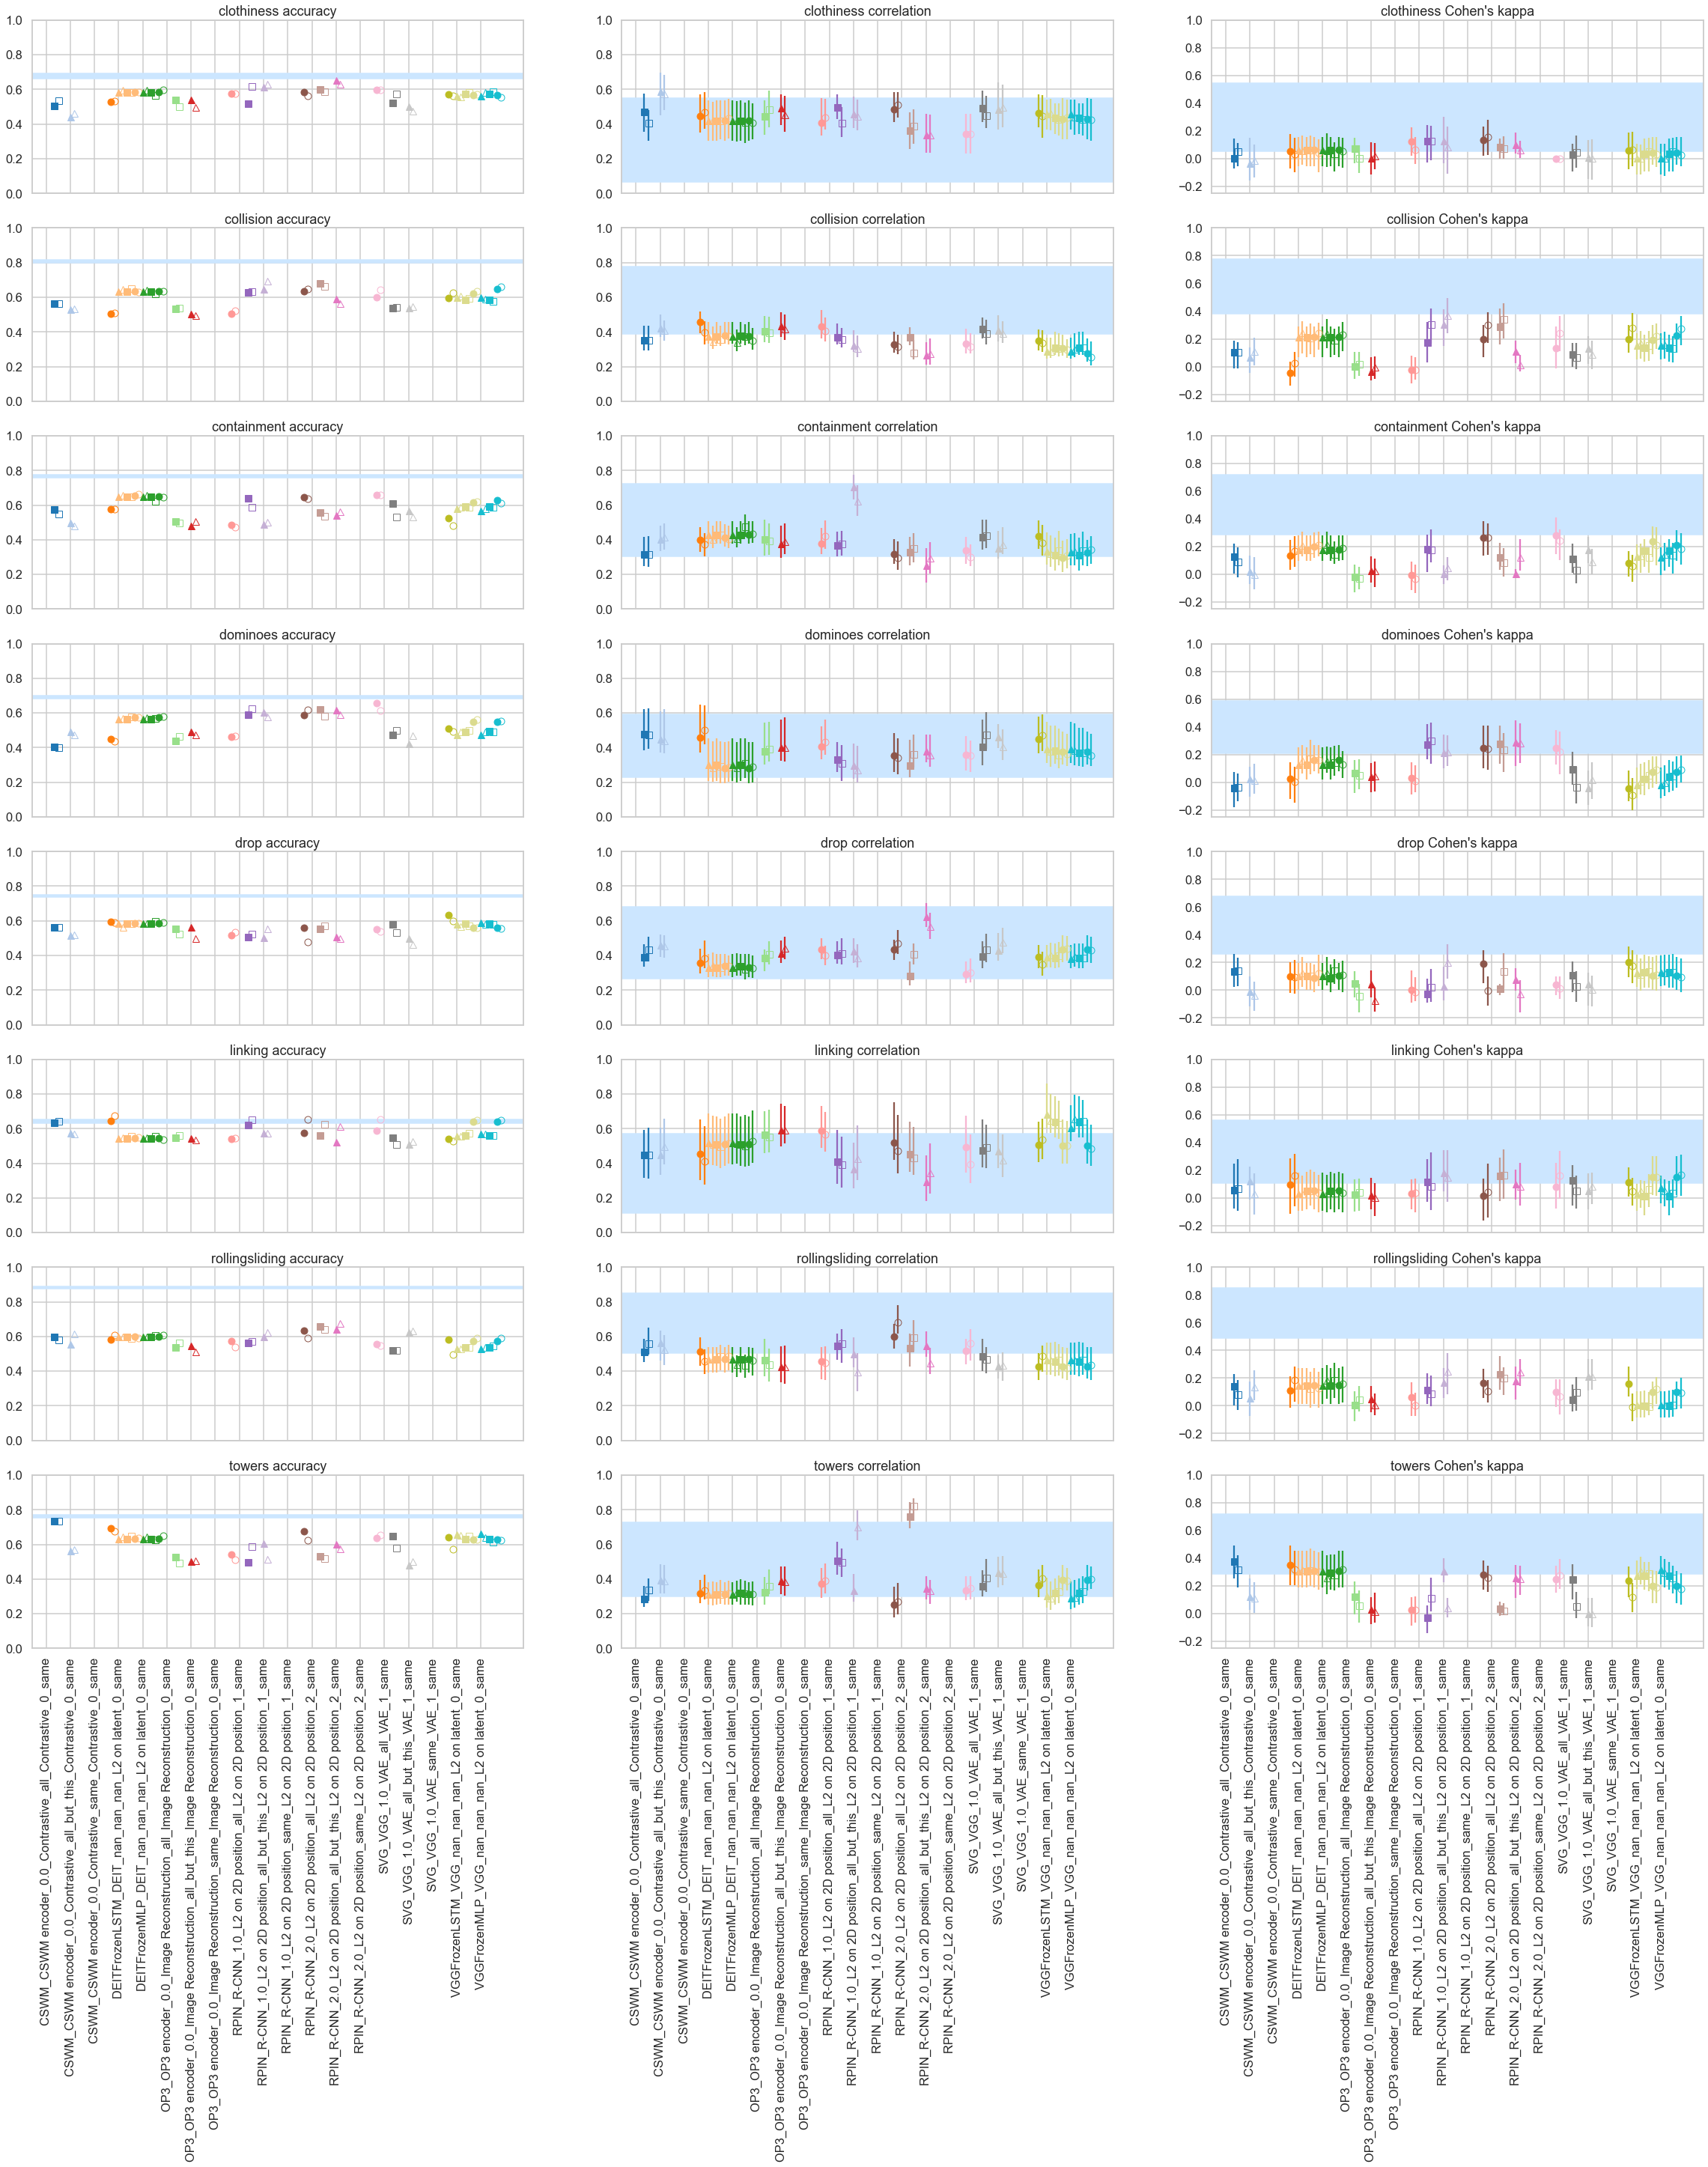

In [51]:
fig, axes = plt.subplots(len(MD['Readout Test Data'].unique()),3, figsize=(40,40), sharex=True, sharey=False)

models = sorted(MD['Model Kind'].unique())

for outer_y, scenario in enumerate(sorted(MD['Readout Test Data'].unique())):
    # ———accuracy plot———
    axis = axes[outer_y,0]
    axis.set_title(scenario + " accuracy")
    #plot human zone
    human_row = human_bootstrapped_accuracy[human_bootstrapped_accuracy['scenario'] == scenario]
    lb = float(human_row['ci_lb'])
    ub = float(human_row['ci_ub'])
    mean = float(human_row['obs_mean'])
    axis.axhspan(lb,ub,color=(.8,.9,1))
    axis.set_xticks(np.arange(len(models)))
    axis.set_xticklabels(models,rotation=90)
    
    #plot models
    for x,model in enumerate(models):
        #get relevant rows
        rows = model_human_accuracies[(model_human_accuracies['Model Kind'] == model) & (model_human_accuracies['scenario'] == scenario)]
        for readout,fill in READOUTS:
            for i,(training,symbol) in enumerate(TRAININGS):
                row = rows[(rows['Readout Type']==readout) & (rows['Dynamics Training Dataset Type'] == training)]
                if len(row) > 0: #do we have something to plot?
                    assert len(row) == 1, "More than one entry for specific agent"
                    lb = row['model_correct']
                    ub = row['model_correct']
                    measure = row['model_correct']
                    ub = abs(ub - measure)
                    lb = abs(lb - measure)
                    axis.errorbar(x+(i*.333)+(fill=="none")*.166,measure,(lb,ub),marker=symbol,fillstyle=fill,label=model,color=cmap[x])
        axis.set_ybound([0,1])
    
    # ———correlation plot———
    axis = axes[outer_y,1]
    axis.set_title(scenario + " correlation")
    #plot human zone
    human_row = human_boot_corr[human_boot_corr['scenario'] == scenario]
    lb = float(human_row['corr_lb'])
    ub = float(human_row['corr_ub'])
    mean = float(human_row['corr_med'])
    axis.axhspan(lb,ub,color=(.8,.9,1))
    axis.set_xticks(np.arange(len(models)))
    axis.set_xticklabels(models,rotation=90)

    #plot models
    for x,model in enumerate(models):
        #get relevant rows
        rows = model_human_correlations[(model_human_correlations['Model Kind'] == model) & (model_human_correlations['scenario'] == scenario)]
        for readout,fill in READOUTS:
            for i,(training,symbol) in enumerate(TRAININGS):
                row = rows[(rows['Readout Type']==readout) & (rows['Dynamics Training Dataset Type'] == training)]
                if len(row) > 0: #do we have something to plot?
                    assert len(row) == 1, "More than one entry for specific agent"
                    lb = row['corr_lb']
                    ub = row['corr_ub']
                    measure = row['corr_med']
                    ub = abs(ub - measure)
                    lb = abs(lb - measure)
                    axis.errorbar(x+(i*.333)+(fill=="none")*.166,measure,(lb,ub),marker=symbol,fillstyle=fill,label=model,color=cmap[x])
        axis.set_ybound([0,1])
        
    
    # ———Cohens'k plot———
    axis = axes[outer_y,2]
    axis.set_title(scenario + " Cohen's kappa")
    #plot human zone
    human_row = human_boot_cohenk[human_boot_cohenk['scenario'] == scenario]
    lb = float(human_row['corr_lb'])
    ub = float(human_row['corr_ub'])
    mean = float(human_row['corr_med'])
    axis.axhspan(lb,ub,color=(.8,.9,1))
    axis.set_xticks(np.arange(len(models)))
    axis.set_xticklabels(models,rotation=90)

    #plot models
    for x,model in enumerate(models):
        #get relevant rows
        rows = model_human_CohensK[(model_human_CohensK['Model Kind'] == model) & (model_human_CohensK['scenario'] == scenario)]
        for readout,fill in READOUTS:
            for i,(training,symbol) in enumerate(TRAININGS):
                row = rows[(rows['Readout Type']==readout) & (rows['Dynamics Training Dataset Type'] == training)]
                if len(row) > 0: #do we have something to plot?
                    assert len(row) == 1, "More than one entry for specific agent"
                    lb = row['Cohens_k_lb']
                    ub = row['Cohens_k_ub']
                    measure = row['Cohens_k_med']
                    ub = abs(ub - measure)
                    lb = abs(lb - measure)
                    axis.errorbar(x+(i*.333)+(fill=="none")*.166,measure,(lb,ub),marker=symbol,fillstyle=fill,color=cmap[x])
        axis.set_ybound([-.25
                         ,1])